<h1>ENSO Teleconnections - WIND (DO NOT DISTRIBUTE)</h1>

In [1]:
import os
import sys
import gc
import collections
from io import BytesIO
from PIL import Image
import xarray as xr
import matplotlib.pyplot as plt

# Point to root directory of repository
root_dir = os.path.join(os.getcwd(), '..')
if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

from src.datareader import datareader as dr
from src.util import oni

<h5>User Configurables</h5>

In [2]:
ufs_model = 'beta.0.1'

In [3]:
ufs_var = 'u'
era5_var = 'u_component_of_wind'
lev = 200

In [4]:
time_range = ("1994-11-01","2021-02-28T23")
# time_range = ("2015-11-01","2021-02-28T23")
initmonth = 11  # Get only these forecasts
leads = (0, 1, 2, 3)  # Form Composites around these leads.  User may select just 1 lead, like leads=(1,)

In [5]:
# Define a region over which to calculate correlation
# You can ignore region by setting it to None
# region = None
region = {
    'latmin': -5.0,
    'latmax': 5.0,
    'lonmin': 190.0,
    'lonmax': 240.0
}

In [6]:
# Filter ONI events per specific criteria.
strength = None  # For example, you can set strength = 'Weak', 'Moderate', 'Strong', or 'Very Strong'
oni_threshold = None  # For example, you can set oni_threshold = 3

<h3>El Niño Events</h3>

In [7]:
oni.elnino_events  # These have been prerecorded

((1951, 1.2),
 (1952, 0.8),
 (1953, 0.8),
 (1957, 1.8),
 (1958, 0.6),
 (1963, 1.4),
 (1965, 1.9),
 (1968, 1.1),
 (1969, 0.9),
 (1972, 1.8),
 (1976, 0.9),
 (1977, 0.8),
 (1979, 0.6),
 (1982, 2.2),
 (1986, 1.2),
 (1987, 1.7),
 (1991, 1.7),
 (1994, 1.1),
 (1997, 2.4),
 (2002, 1.3),
 (2004, 0.7),
 (2006, 0.94),
 (2009, 1.36),
 (2014, 0.93),
 (2015, 2.64),
 (2018, 0.9),
 (2023, 1.95))

<h3>La Niña Events</h3>

In [8]:
oni.lanina_events  # These have been prerecorded

((1954, -0.9),
 (1955, -1.4),
 (1964, -0.8),
 (1970, -1.4),
 (1971, -0.9),
 (1973, -1.9),
 (1974, -0.8),
 (1975, -1.7),
 (1983, -0.9),
 (1984, -0.9),
 (1988, -1.8),
 (1995, -1.0),
 (1998, -1.6),
 (1999, -1.7),
 (2000, -0.7),
 (2005, -0.85),
 (2007, -1.64),
 (2008, -0.85),
 (2010, -1.64),
 (2011, -1.09),
 (2016, -0.69),
 (2017, -0.97),
 (2020, -1.27),
 (2021, -1.06),
 (2022, -0.99))

<h3>Create ONI objects for each event</h3>

In [9]:
ElNinos = [oni.ONI(event[0], event[1]) for event in oni.elnino_events]
LaNinas = [oni.ONI(event[0], event[1]) for event in oni.lanina_events]

In [10]:
elnino_strengths = [nino.get('strength') for nino in ElNinos]
lanina_strengths = [nina.get('strength') for nina in LaNinas]

In [11]:
collections.Counter(elnino_strengths)

Counter({'Weak': 11, 'Moderate': 7, 'Strong': 6, 'Very Strong': 3})

In [12]:
collections.Counter(lanina_strengths)

Counter({'Weak': 12, 'Strong': 7, 'Moderate': 6})

<h3>Get El Niño / La Niña years per specific criteria</h3>

In [13]:
# El Nino years
elnino_years = []
for nino in ElNinos:
    if strength is not None and nino.get('strength') != strength:
        continue      
    if oni_threshold is not None and nino.get('oni_magnitude') < oni_threshold:
        continue     
    elnino_years.append(nino.get('year'))

# La Nina
lanina_years = []
for nina in LaNinas:
    if strength is not None and nina.get('strength') != strength:
        continue      
    if oni_threshold is not None and nina.get('oni_magnitude') < oni_threshold:
        continue     
    lanina_years.append(nina.get('year'))
    
# Print El Nino years
print("Number of El Nino years: ", len(elnino_years))
for this_year in elnino_years:
    print(this_year, end=' ')
    
print('\n')

# Print La Nina years
print("Number of La Nina years: ", len(lanina_years))
for this_year in lanina_years:
    print(this_year, end=' ')
    

Number of El Nino years:  27
1951 1952 1953 1957 1958 1963 1965 1968 1969 1972 1976 1977 1979 1982 1986 1987 1991 1994 1997 2002 2004 2006 2009 2014 2015 2018 2023 

Number of La Nina years:  25
1954 1955 1964 1970 1971 1973 1974 1975 1983 1984 1988 1995 1998 1999 2000 2005 2007 2008 2010 2011 2016 2017 2020 2021 2022 

In [14]:
# Our model data doesn't go back to year 1950, nor does it reach the present, so what years are remaining?

begin_year = int(time_range[0][0:4])
end_year = int(time_range[1][0:4])

# print(begin_year)
# print(end_year)
# print('')

elnino_years_in_data = [y for y in elnino_years if y >= begin_year and y <= end_year]
lanina_years_in_data = [y for y in lanina_years if y >= begin_year and y <= end_year]

print('El Nino in data:')
print(elnino_years_in_data)
print('')
print('La Nina in data:')
print(lanina_years_in_data)

El Nino in data:
[1994, 1997, 2002, 2004, 2006, 2009, 2014, 2015, 2018]

La Nina in data:
[1995, 1998, 1999, 2000, 2005, 2007, 2008, 2010, 2011, 2016, 2017, 2020, 2021]


<h1>Get UFS and ERA5 datasets</h1>

<h5>Call a utility that prepares the UFS and ERA5 data for us.</h5>
<h5>Read data from source, resample and regrid ERA5 data, and compute climatology statistics and anomalies for El Nino and La Nina events.</h5>
<h5>(This may take a couple minutes to finish!)</h5>

In [15]:
ufs_elnino_statistics, ufs_lanina_statistics, era5_elnino_statistics, era5_lanina_statistics =\
oni.prep_oni_datasets(statistics           = 'anomaly',
                      ufs_model            = ufs_model,
                      ufs_var              = ufs_var,
                      verif_var            = era5_var,
                      time_range           = time_range,
                      initmonth            = initmonth,
                      leads                = leads,
                      elnino_years         = elnino_years,
                      lanina_years         = lanina_years,
                      lev                  = lev,
                      ufs_scaling_factor   = None,
                      verif_scaling_factor = None)

Reading data from s3://noaa-oar-sfsdev-pds/experiments/phase_1/beta.0.1/atm_monthly.zarr
No filename provided; deferring to default
Reading data from gs://gcp-public-data-arco-era5/ar/1959-2022-6h-512x256_equiangular_conservative.zarr

Regrid Object initialized.

___Resample Instructions___
data_reader2 must be temporally resampled before spatially regridding.
Resample these data by running <RegridObj>.resample(var=<var>, lev=<lev>, time=<time_range>)
To see all variables available for resample, run <RegridObj>.resample_vars()

___Regrid Instructions___
Initialized the Regridder with method 'bilinear'
Input grid shape data_reader1 (UFS_DataReader): lat 361, lon 720
Output grid shape data_reader2 (ERA5_DataReader): lat 256, lon 512
Regrid these data by running <RegridObj>.regrid(var=<var>, lev=<lev>, time=<time_range>)
To see all variables available for regrid, run <RegridObj>.regrid_vars()

___Align Instructions___
data_reader2 can have its time coordinates converted to init+lead.
Lead

/home/thamzey/ufs_model_evaluation/notebooks/../src/regridder/Regrid.py:769: UserWarning: Verif data not available for 10 timesteps, filled with NaN.
  warnings.warn(msg)


Calculating climatology statistics and anomalies.
ONI Datasets Ready.


In [16]:
# When the above cell finishes running, you should see:
# "ONI Datasets Ready."

<p>
---------------------------------------------------------------<br>
We now have 4 datasets of statistics:<br>
<br>
ufs_elnino_statistics<br>
ufs_lanina_statistics<br>
era5_elnino_statistics<br>
era5_lanina_statistics<br>
(^The original data is preserved alongside the anomaly results)<br>
---------------------------------------------------------------
</p>

<h3>Calculate composites and plot</h3>

In [17]:
# This is the DataArray for the Composite
ufs_elnino_composite = ufs_elnino_statistics['anomaly'].sel(lead=list(leads)).mean(['init', 'lead'])
ufs_lanina_composite = ufs_lanina_statistics['anomaly'].sel(lead=list(leads)).mean(['init', 'lead'])

era5_elnino_composite = era5_elnino_statistics['anomaly'].sel(lead=list(leads)).mean(['init', 'lead'])
era5_lanina_composite = era5_lanina_statistics['anomaly'].sel(lead=list(leads)).mean(['init', 'lead'])

# Calculate the difference in anomalies
elnino_era5_minus_ufs = era5_elnino_composite - ufs_elnino_composite
lanina_era5_minus_ufs = era5_lanina_composite - ufs_lanina_composite

# Calculate Correlations
elnino_corr = xr.corr(ufs_elnino_composite, era5_elnino_composite).values.item()
lanina_corr = xr.corr(ufs_lanina_composite, era5_lanina_composite).values.item()

# Calculate Correlations over a smaller region
if region is not None:
    
    # latitudes are ordered 90 to -90
    lat_slice = slice(region['latmax'], region['latmin'])
    lon_slice = slice(region['lonmin'], region['lonmax'])
    
    elnino_corr_region = xr.corr(ufs_elnino_composite.sel(lat=lat_slice, lon=lon_slice),
                                 era5_elnino_composite.sel(lat=lat_slice, lon=lon_slice)).values.item()
    
    lanina_corr_region = xr.corr(ufs_lanina_composite.sel(lat=lat_slice, lon=lon_slice),
                                 era5_lanina_composite.sel(lat=lat_slice, lon=lon_slice)).values.item()

<h5>Make labels for the plots</h5>

In [18]:
elnino_event_years = list(ufs_elnino_statistics.groupby('init.year').groups.keys())
lanina_event_years = list(ufs_lanina_statistics.groupby('init.year').groups.keys())

# Convert every year into 'YY for compactness.
elnino_event_years = [f"'{str(y)[2:4]}" for y in elnino_event_years]
lanina_event_years = [f"'{str(y)[2:4]}" for y in lanina_event_years]

elnino_event_years = f"Events: {' '.join([f'{y}' for y in elnino_event_years])}"  # convert to string
lanina_event_years = f"Events: {' '.join([f'{y}' for y in lanina_event_years])}"  # convert to string

# Label for init and leads
initlead_label = f"init {initmonth}\nlead {' '.join(filter(str.isdigit, str(leads)))}"

# Label for correlation
elnino_corr_label = f'corr: {elnino_corr:.2f}'
lanina_corr_label = f'corr: {lanina_corr:.2f}'

if region is not None:
    elnino_corr_label = f'{elnino_corr_label}\nregion: {elnino_corr_region:.2f}'
    lanina_corr_label = f'{lanina_corr_label}\nregion: {lanina_corr_region:.2f}'

<h3>Generate figures</h3>

In [19]:
%%capture captured_output

# Instantiate buffers
buffer1 = BytesIO()
buffer2 = BytesIO()
buffer3 = BytesIO()
buffer4 = BytesIO()
buffer5 = BytesIO()
buffer6 = BytesIO()

# Make 6 plots
plot_kwargs = {'cmap_label': 'm s-1',
               'cmap': 'custom_btr',
               'topleft_label': initlead_label,
               'region': region}

plot1 = oni.plot_composite(da = era5_elnino_composite,
                           title=f'ERA5 Zonal Wind Anomaly lev={lev} (El Nino)',
                           vmin=-9, vmax=9,
                           subtitle=elnino_event_years, **plot_kwargs)

plt.savefig(buffer1, format='png', bbox_inches='tight')
# -----------------------------------------------------------------------------

plot2 = oni.plot_composite(da = era5_lanina_composite,
                           title=f'ERA5 Zonal Wind Anomaly lev={lev} (La Nina)',
                           vmin=-9, vmax=9,
                           subtitle=lanina_event_years, **plot_kwargs)

plt.savefig(buffer2, format='png', bbox_inches='tight')
# -----------------------------------------------------------------------------

plot3 = oni.plot_composite(da = ufs_elnino_composite,
                           title=f'UFS Zonal Wind Anomaly lev={lev} (El Nino)',
                           vmin=-9, vmax=9,
                           subtitle=elnino_event_years, **plot_kwargs)

plt.savefig(buffer3, format='png', bbox_inches='tight')
# -----------------------------------------------------------------------------

plot4 = oni.plot_composite(da = ufs_lanina_composite,
                           title=f'UFS Zonal Wind Anomaly lev={lev} (La Nina)',
                           vmin=-9, vmax=9,
                           subtitle=lanina_event_years, **plot_kwargs)

plt.savefig(buffer4, format='png', bbox_inches='tight')
# -----------------------------------------------------------------------------

plot5 = oni.plot_composite(da = elnino_era5_minus_ufs,
                           title=f'ERA5 minus UFS Zonal Wind Anomaly lev={lev} (El Nino)',
                           vmin=-4, vmax=4,
                           subtitle=elnino_event_years,
                           bottomright_label=elnino_corr_label,
                           **plot_kwargs)

plt.savefig(buffer5, format='png', bbox_inches='tight')
# -----------------------------------------------------------------------------

plot6 = oni.plot_composite(da = lanina_era5_minus_ufs,
                           title=f'ERA5 minus UFS Zonal Wind Anomaly lev={lev} (La Nina)',
                           vmin=-4, vmax=4,
                           subtitle=lanina_event_years,
                           bottomright_label=lanina_corr_label,
                           **plot_kwargs)

plt.savefig(buffer6, format='png', bbox_inches='tight')
# -----------------------------------------------------------------------------


<h3>Construct 3 row x 2 column multi-paneled image</h3>

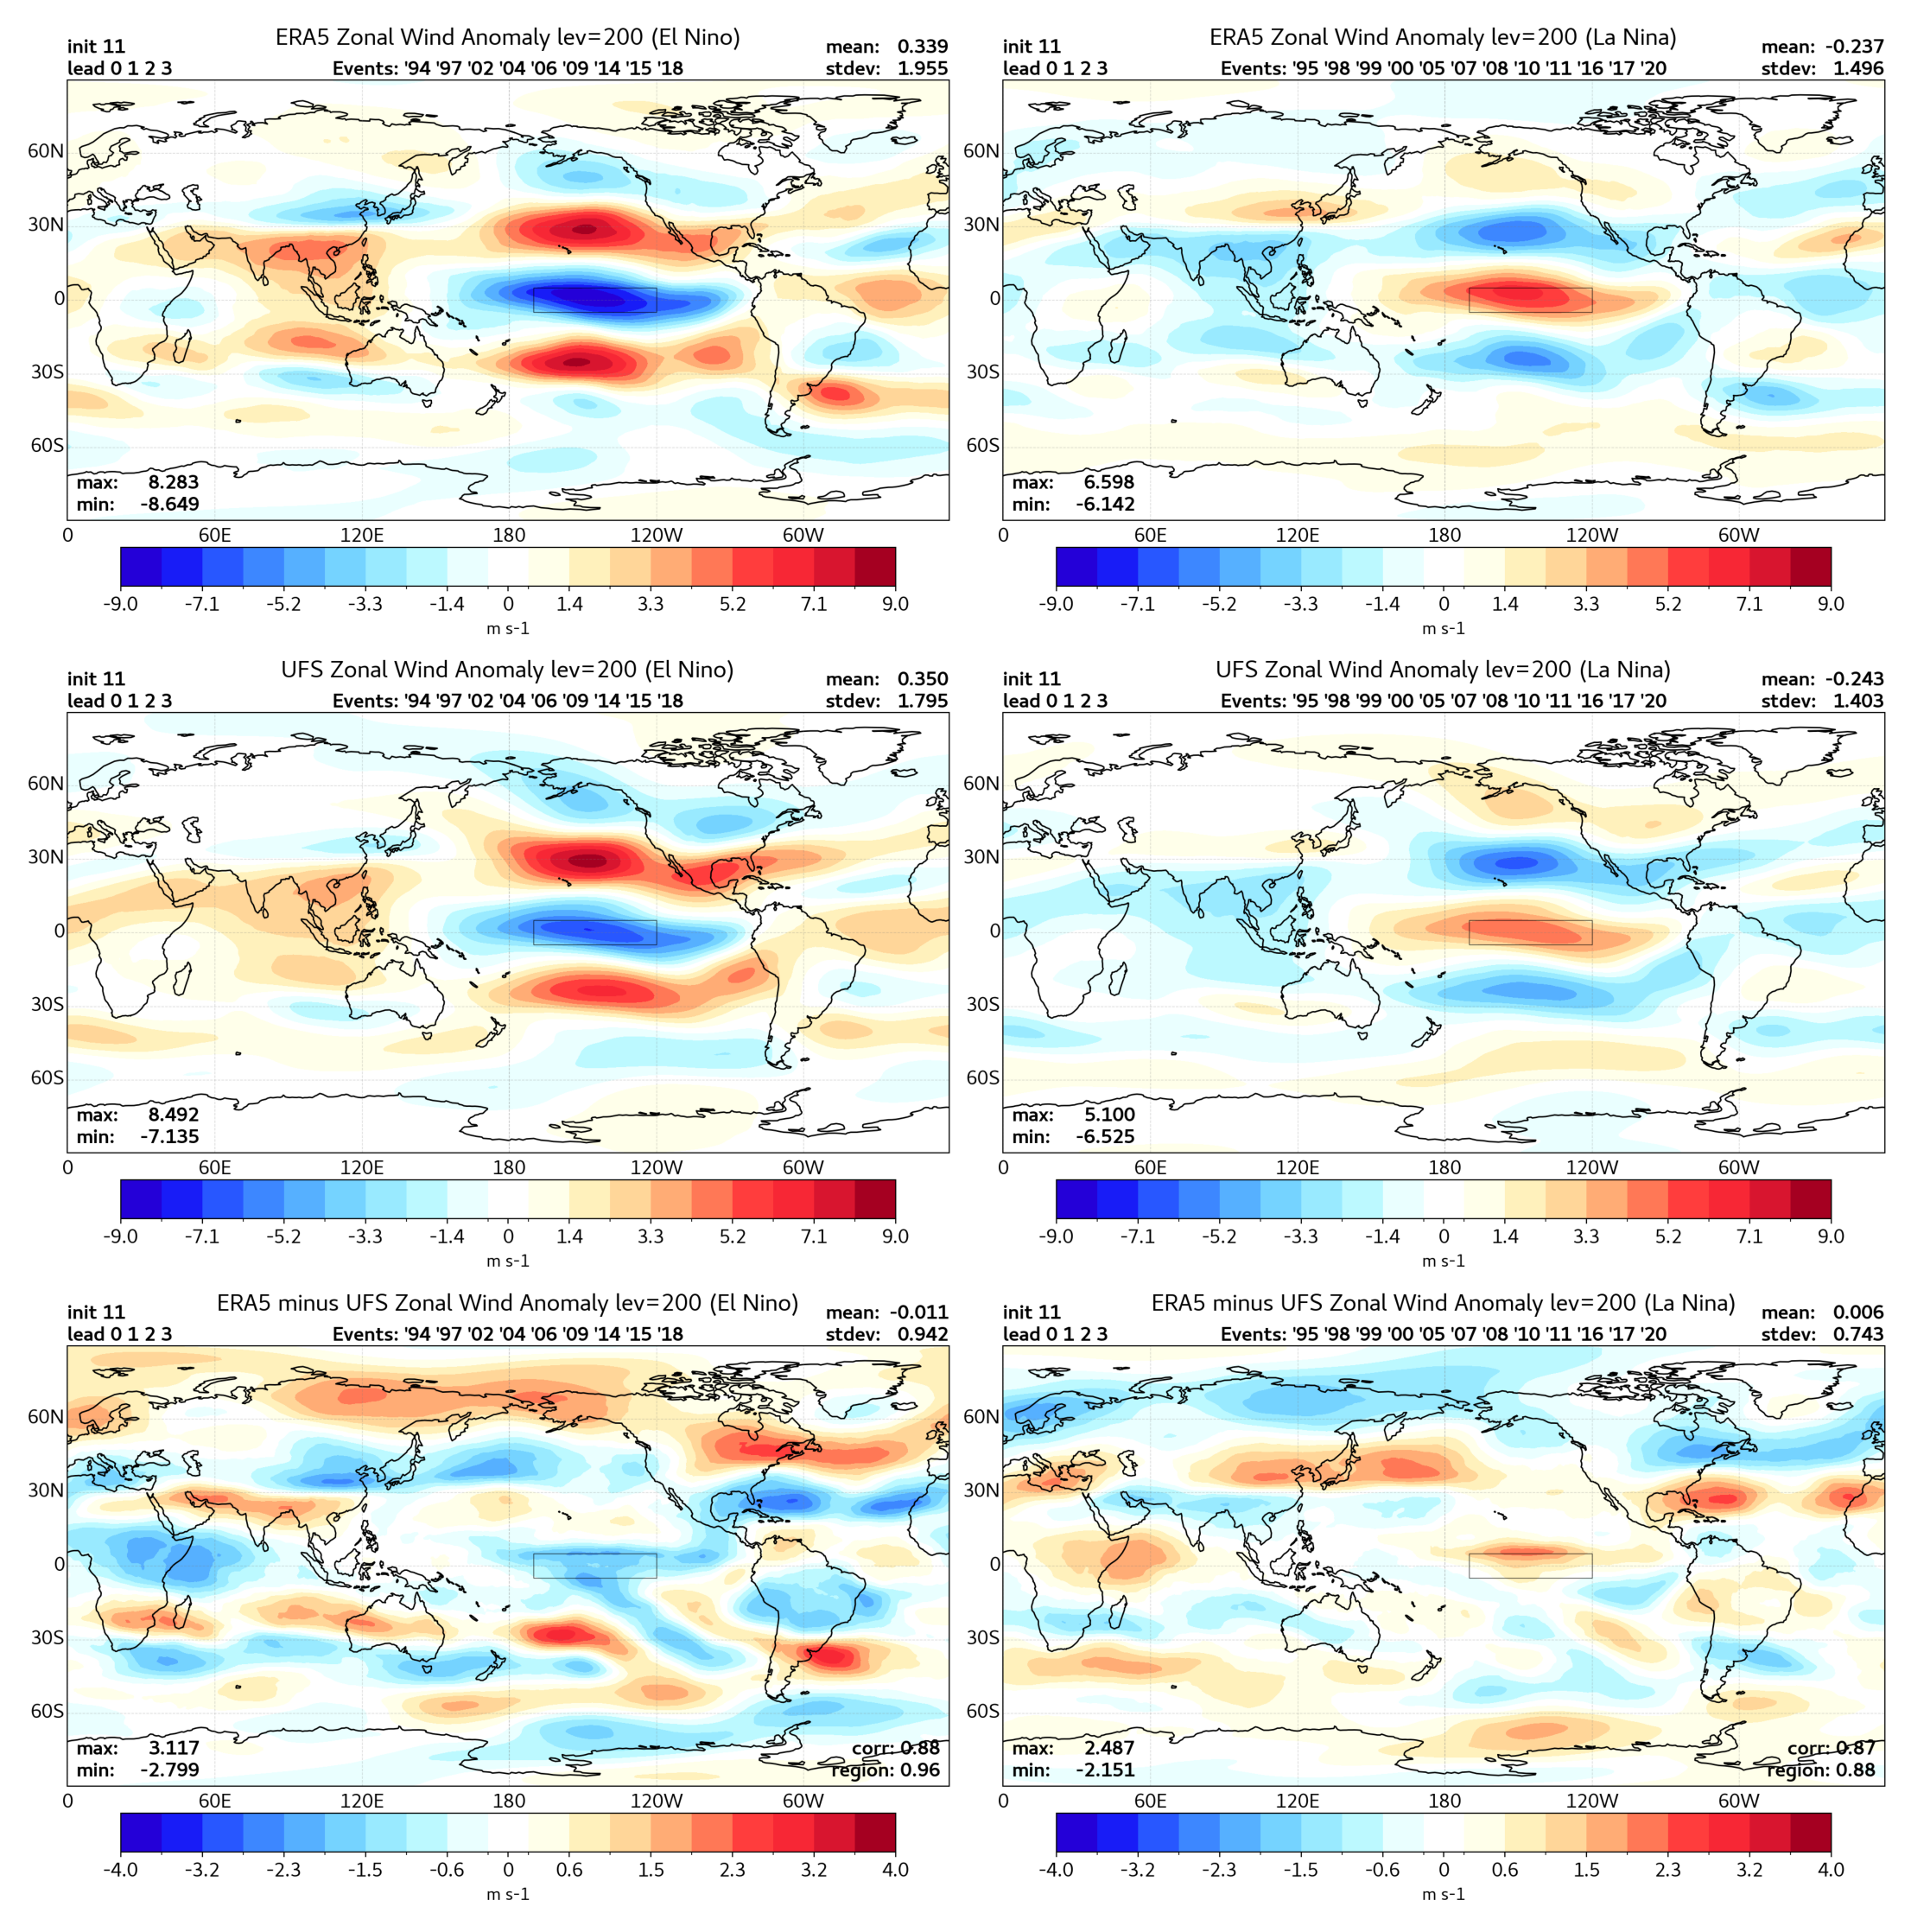

In [20]:
# Convert to images
image1 = Image.open(buffer1)
image2 = Image.open(buffer2)
image3 = Image.open(buffer3)
image4 = Image.open(buffer4)
image5 = Image.open(buffer5)
image6 = Image.open(buffer6)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 11), dpi=200)

axs[0, 0].imshow(image1)
axs[0, 0].axis('off')

axs[0, 1].imshow(image2)
axs[0, 1].axis('off')

axs[1, 0].imshow(image3)
axs[1, 0].axis('off')

axs[1, 1].imshow(image4)
axs[1, 1].axis('off')

axs[2, 0].imshow(image5)
axs[2, 0].axis('off')

axs[2, 1].imshow(image6)
axs[2, 1].axis('off')

plt.gca().set_frame_on(False)
plt.tight_layout(pad=.05)
plt.show()

In [21]:
del buffer1, buffer2, buffer3, buffer4, buffer5, buffer6
del image1, image2, image3, image4, image5, image6
del plot1, plot2, plot3, plot4, plot5, plot6, plt
gc.collect()

0